# Code to generate initial forcing conditions for COMBLE LES/SCM intercomparison
### Developed by Tim Juliano at NCAR/RAL on 8/26/22

### Import libraries

In [259]:
import netCDF4
import numpy as np
import numpy.ma as ma
import sys
from netCDF4 import Dataset, date2num,num2date
import datetime as dt
import os
import matplotlib.pyplot as plt
from scipy import interpolate

### Forcing NetCDF name and delete file if already exists

In [260]:
savename = 'COMBLE_INTERCOMPARISON_FORCING.nc'

if os.path.exists(savename):
    os.remove(savename)
    print('The file ' + savename + ' has been deleted successfully')

The file COMBLE_INTERCOMPARISON_FORCING.nc has been deleted successfully


### Get LES domain locations

In [261]:
fname = 'LES_domain_location_Mar13_2020_trimmed.txt'

les_loc = np.loadtxt(fname,skiprows=1)
les_hh = les_loc[:,0]
les_lat = les_loc[:,1]
les_lon = les_loc[:,2]

les_lat_mid = 73.0
les_lon_mid = 2.5

### Create vertical grid
#### 160 vertical grid levels, defined at the cell faces

In [262]:
nz = 160

dz_grid = np.empty(nz-1)
dz_grid[0] = 20.0
dz_grid[1] = 25.0
dz_grid[2] = 30.0
dz_grid[3] = 35.0
dz_grid[4:140] = 40.0
dz_grid[140] = 60.0
dz_grid[141:157] = 80.0
dz_grid[157] = 60.0
dz_grid[158] = 50.0

z_grid = np.empty(nz)
z_grid[0] = 0.0
for i in np.arange(1,len(z_grid)):
    z_grid[i] = z_grid[i-1] + dz_grid[i-1]

### Read in data from ERA5 backtrajectory (netCDF)

In [263]:
# File name
fname = 'theta_temp_rh_sh_uvw_sst_along_trajectory_end_2020-03-13-18.nc'

# Open dataset
dataset = netCDF4.Dataset(fname, "r")

# Read variables (1D arrays are time, 2D arrays are time x pressure level)
hours = dataset.variables['Time'][:]
lat = dataset.variables['Latitude'][:]
lon = dataset.variables['Longitude'][:]
pres = dataset.variables['Pressure'][:]
sfc_pres = dataset.variables['SfcPres'][:]
sst = dataset.variables['SST'][:]
hgt = dataset.variables['GEOS_HT'][:,:]
uwnd = dataset.variables['U'][:,:]
vwnd = dataset.variables['V'][:,:]
wwnd = dataset.variables['W'][:,:]
temp = dataset.variables['Temp'][:,:]
theta = dataset.variables['Theta'][:,:]
qv = dataset.variables['SH'][:,:]

### Convert units

In [264]:
sfc_pres_pa = sfc_pres/100.  # Pa to hPa

### Reverse time dimension of 2D arrays, as well as sfc pressure and sst, so that beginning of backward trajectory is in first position

In [265]:
hgt = np.flip(hgt,axis=0)
uwnd = np.flip(uwnd,axis=0)
vwnd = np.flip(vwnd,axis=0)
wwnd = np.flip(wwnd,axis=0)
temp = np.flip(temp,axis=0)
theta = np.flip(theta,axis=0)
qv = np.flip(qv,axis=0)
sfc_pres_pa = sfc_pres_pa[::-1]
sst = sst[::-1]

### Unmask sst field and determine ~ice edge (t0=18h after backtrajectory initialization from Andenes, or 3/13/20 at 00 UTC)

In [266]:
sst_real = ma.getdata(sst)
loopidx = np.where(sst_real>0.0)[0]
t0 = loopidx[6]

### Calculate sfc potential temperature

In [267]:
theta1000mb = theta[:,0]
sfc_theta = theta1000mb*pow((1000./sfc_pres_pa),0.286)

### Get information at t0

In [268]:
z1 = 1

pres_t0 = pres[z1:]
hgt_t0 = hgt[t0,z1:]
uwnd_t0 = uwnd[t0,z1:]
vwnd_t0 = vwnd[t0,z1:]
wwnd_t0 = wwnd[t0,z1:]
temp_t0 = temp[t0,z1:]
theta_t0 = theta[t0,z1:]
qv_t0 = qv[t0,z1:]

ps_t0 = sfc_pres_pa[t0]
thetas_t0 = sfc_theta[t0]

### Get Geostrophic wind forcing

In [269]:
fname2 = 'geostrophic_wind.txt'

geo_winds = np.loadtxt(fname2,skiprows=1)

zgeo = np.empty([19,len(pres_t0)])
ugeo = np.empty([19,len(pres_t0)])
vgeo = np.empty([19,len(pres_t0)])
count = 0
for i in np.arange(18,-1,-1):
        idx = np.where(geo_winds[:,0]==i)[0]
        zgeo[count,:] = geo_winds[idx,1]
        ugeo[count,:] = geo_winds[idx,2]
        vgeo[count,:] = geo_winds[idx,3]

        count+=1

### Interpolate t0 profiles and geostrophic wind profiles to common vertical grid for simplicity

#### Find time with highest first level and get vertical grid

In [270]:
zz1 = np.empty([19,len(pres_t0)])
count = 0
for i in np.arange(18,-1,-1):
        idx = np.where(geo_winds[:,0]==i)[0]
        zz1[count,:] = geo_winds[idx,1]

        count+=1
        
zz1_max_idx = np.argmax(zz1[:,0])
zgeoi = zz1[zz1_max_idx,0:-1]

#### Do the linear interpolation of time-varying geostrophic profiles to new vertical grid

In [271]:
ugeoi = np.empty([19,len(pres_t0)-1])
vgeoi = np.empty([19,len(pres_t0)-1])
count = 0
for i in np.arange(19):
    f = interpolate.interp1d(zgeo[i,:], ugeo[i,:])
    ugeoi[count,:] = f(zgeoi)
    f = interpolate.interp1d(zgeo[i,:], vgeo[i,:])
    vgeoi[count,:] = f(zgeoi)
    
    count+=1

#### Compare original and interpolated profiles of time-varying geostrophic wind as example to show efficacy of method

<Figure size 432x288 with 0 Axes>

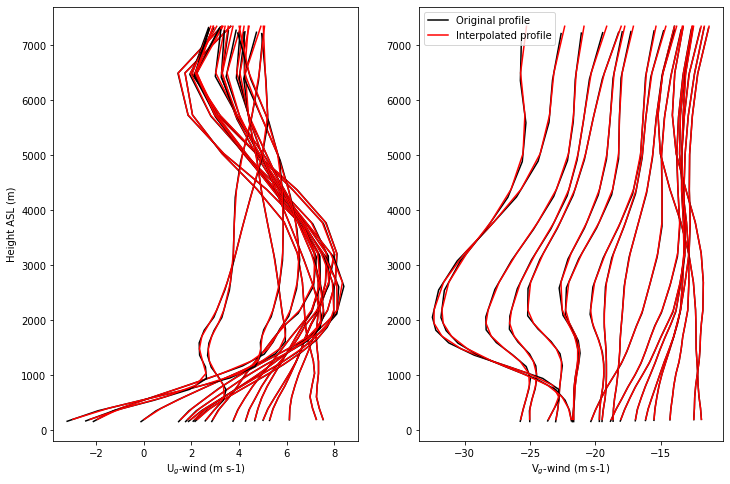

In [272]:
zplt1 = 0
zplt2 = 18

plt.figure()
plt.figure(figsize=(12,8))

var_plt1 = ugeo
var_plt2 = ugeoi
plt.subplot(121)
for i in np.arange(19):
    if i == 0:
        plt.plot(var_plt1[i,zplt1:zplt2],zgeo[i,zplt1:zplt2],c='k')
        plt.plot(var_plt2[i,zplt1:zplt2],zgeoi[zplt1:zplt2],c='r')
    else:
        plt.plot(var_plt1[i,zplt1:zplt2],zgeo[i,zplt1:zplt2],c='k')
        plt.plot(var_plt2[i,zplt1:zplt2],zgeoi[zplt1:zplt2],c='r')
plt.xlabel('U$_{g}$-wind (m s-1)')
plt.ylabel('Height ASL (m)')
        
var_plt1 = vgeo
var_plt2 = vgeoi
plt.subplot(122)
for i in np.arange(19):
    if i == 0:
        plt.plot(var_plt1[i,zplt1:zplt2],zgeo[i,zplt1:zplt2],c='k',label='Original profile')
        plt.plot(var_plt2[i,zplt1:zplt2],zgeoi[zplt1:zplt2],c='r',label='Interpolated profile')
    else:
        plt.plot(var_plt1[i,zplt1:zplt2],zgeo[i,zplt1:zplt2],c='k')
        plt.plot(var_plt2[i,zplt1:zplt2],zgeoi[zplt1:zplt2],c='r')
plt.xlabel('V$_{g}$-wind (m s-1)')
plt.legend()
plt.show()

#### Do the linear interpolation for initial forcing profiles

In [273]:
f = interpolate.interp1d(hgt_t0, pres_t0)
pres_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, uwnd_t0)
uwnd_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, vwnd_t0)
vwnd_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, wwnd_t0)
wwnd_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, temp_t0)
temp_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, theta_t0)
theta_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, qv_t0)
qv_t0i = f(zgeoi)

#### Compare original and interpolated intial profiles as example to show efficacy of method

<Figure size 432x288 with 0 Axes>

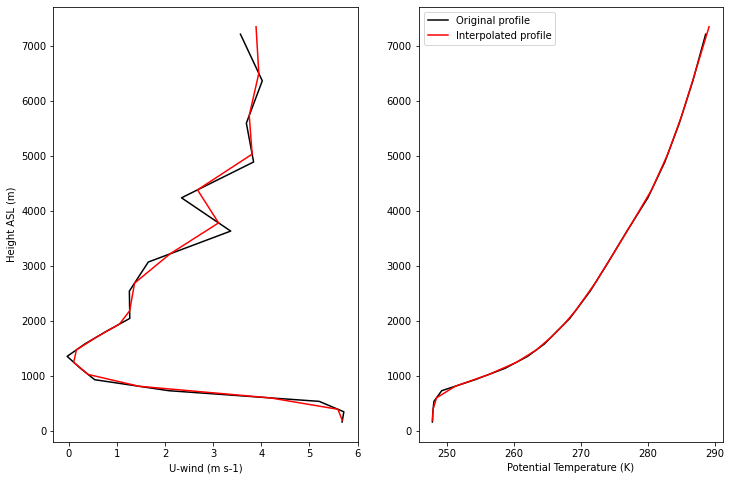

In [274]:
zplt1 = 0
zplt2 = 18

plt.figure()
plt.figure(figsize=(12,8))

var_plt1 = uwnd_t0
var_plt2 = uwnd_t0i
plt.subplot(121)
plt.plot(var_plt1[zplt1:zplt2],hgt_t0[zplt1:zplt2],c='k')
plt.plot(var_plt2[zplt1:zplt2],zgeoi[zplt1:zplt2],c='r')
plt.xlabel('U-wind (m s-1)')
plt.ylabel('Height ASL (m)')
        
var_plt1 = theta_t0
var_plt2 = theta_t0i
plt.subplot(122)
plt.plot(var_plt1[zplt1:zplt2],hgt_t0[zplt1:zplt2],c='k',label='Original profile')
plt.plot(var_plt2[zplt1:zplt2],zgeoi[zplt1:zplt2],c='r',label='Interpolated profile')
plt.xlabel('Potential Temperature (K)')
plt.legend()
plt.show()

### Get time series information for sfc forcing

In [275]:
sst_ts = sst[t0:]

### Create new netcdf file

In [276]:
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfile = Dataset('./' + savename,mode='w',format='NETCDF3_CLASSIC') 
#print(ncfile)

### Create dimensions

In [277]:
hours = 19
levs = len(zgeoi)
z_grid_levs = len(z_grid)
t0_dim = ncfile.createDimension('t0', 1)     # initial time axis
lat_dim = ncfile.createDimension('lat', 1)     # latitude axis
lon_dim = ncfile.createDimension('lon', 1)     # longitude axis
lev_dim = ncfile.createDimension('lev', levs)      # level axis
zw_grid_dim = ncfile.createDimension('zw_grid', z_grid_levs)      # zw_grid axis
time_dim = ncfile.createDimension('time', None)    # unlimited axis (can be appended to)
#for dim in ncfile.dimensions.items():
#    print(dim)

### Create global attributes

In [278]:
ncfile.title='Forcing and initial conditions for 13 March 2020 COMBLE intercomparison case'
ncfile.reference='https://comble-intercomparison.readthedocs.io/en/latest/'
ncfile.authors='Timothy W. Juliano (NCAR/RAL, tjuliano@ucar.edu); Florian Tornow (NASA/GISS, ft2544@columbia.edu); Ann M. Fridlind (NASA/GISS, ann.fridlind@nasa.gov)'
ncfile.version='Created on 2022-09-08'
ncfile.format_version='DEPHY SCM format version 1'
ncfile.script='create_comble_forcing.ipynb'
ncfile.startDate='2020-03-13 00:00:00'
ncfile.endDate='2020-03-13 18:00:00'
ncfile.rad_temp=0
ncfile.force_geo=1
ncfile.surfaceType='ocean'
ncfile.surfaceForcing='ts'
ncfile.surfaceForcingWind='z0'
ncfile.z0=0.01
ncfile.lat=str(les_lat_mid) + ' deg N'
ncfile.dx='150 m'
ncfile.dy='150 m'
ncfile.dz='see zw_grid variable'
ncfile.nx='648'
ncfile.ny='648'
ncfile.nz='160'

### Create variables

#### Dimensions

In [279]:
t0_time = ncfile.createVariable('t0', np.float32, ('t0',))
t0_time.units = 'seconds since 2020-03-13 00:00:00'
t0_time.long_name = 'Initial time'

latitude = ncfile.createVariable('lat', np.float32, ('lat',))
latitude.units = 'degrees_north'
latitude.long_name = 'latitude'

longitude = ncfile.createVariable('lon', np.float32, ('lon',))
longitude.units = 'degrees_east'
longitude.long_name = 'longitude'

time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'seconds since 2020-03-13 00:00:00'
time.long_name = 'time'

lev = ncfile.createVariable('lev', np.float64, ('lev',))
lev.units = 'm'
lev.long_name = 'altitude'

#### Initial profiles

In [280]:
pressure = ncfile.createVariable('pressure', np.float64, ('t0','lev','lat','lon',))
pressure.units = 'Pa'
pressure.long_name = 'pressure'

u = ncfile.createVariable('u', np.float64, ('t0','lev','lat','lon',))
u.units = 'm s-1'
u.long_name = 'zonal wind'

v = ncfile.createVariable('v', np.float64, ('t0','lev','lat','lon',))
v.units = 'm s-1'
v.long_name = 'meridional wind'

temperature = ncfile.createVariable('temp', np.float64, ('t0','lev','lat','lon',))
temperature.units = 'K'
temperature.long_name = 'temperature'

ptemperature = ncfile.createVariable('theta', np.float64, ('t0','lev','lat','lon',))
ptemperature.units = 'K'
ptemperature.long_name = 'potential temperature'

qvapor = ncfile.createVariable('qv', np.float64, ('t0','lev','lat','lon',))
qvapor.units = 'kg kg-1'
qvapor.long_name = 'specific humidity'

#### Initial sfc conditions

In [281]:
ps = ncfile.createVariable('ps', np.float64, ('t0','lat','lon',))
ps.units = 'Pa'
ps.long_name = 'surface pressure'

thetas = ncfile.createVariable('thetas', np.float64, ('t0','lat','lon',))
thetas.units = 'K'
thetas.long_name = 'surface potential temperature'

#### Time-varying forcing

In [282]:
ug = ncfile.createVariable('ug', np.float64, ('time','lev',))
ug.units = 'm s-1'
ug.long_name = 'geostrophic zonal wind'

vg = ncfile.createVariable('vg', np.float64, ('time','lev',))
vg.units = 'm s-1'
vg.long_name = 'geostrophic meridional wind'

ts = ncfile.createVariable('ts', np.float64, ('time',))
ts.units = 'K'
ts.long_name = 'surface temperature'

#### Misc

In [283]:
zw_grid = ncfile.createVariable('zw_grid', np.float64, ('zw_grid',))
zw_grid.units = 'm'
zw_grid.long_name = 'grid altitude at cell faces'

### Write data

In [284]:
t0_time[:] = 0.0
latitude[:] = les_lat_mid
longitude[:] = les_lon_mid
lev[:] = zgeoi
zw_grid[:] = z_grid
pressure[:] = pres_t0i
u[:] = uwnd_t0i
v[:] = vwnd_t0i
temperature[:] = temp_t0i
ptemperature[:] = theta_t0i
qvapor[:] = qv_t0i

ps[:] = ps_t0
thetas[:] = thetas_t0

ug[:] = ugeoi
vg[:] = vgeoi
ts[:] = sst_ts

### Add times

In [285]:
dates = []
for i in np.arange(hours):
    dates.append(dt.datetime(2020,3,13,i))
times = date2num(dates, time.units)
time[:] = times

### Close the file

In [286]:
# first print the Dataset object to see what we've got
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: Forcing and initial conditions for 13 March 2020 COMBLE intercomparison case
    reference: https://comble-intercomparison.readthedocs.io/en/latest/
    authors: Timothy W. Juliano (NCAR/RAL, tjuliano@ucar.edu); Florian Tornow (NASA/GISS, ft2544@columbia.edu); Ann M. Fridlind (NASA/GISS, ann.fridlind@nasa.gov)
    version: Created on 2022-09-08
    format_version: DEPHY SCM format version 1
    script: create_comble_forcing.ipynb
    startDate: 2020-03-13 00:00:00
    endDate: 2020-03-13 18:00:00
    rad_temp: 0
    force_geo: 1
    surfaceType: ocean
    surfaceForcing: ts
    surfaceForcingWind: z0
    z0: 0.01
    lat: 73.0 deg N
    dx: 150 m
    dy: 150 m
    dz: see zw_grid variable
    nx: 648
    ny: 648
    nz: 160
    dimensions(sizes): t0(1), lat(1), lon(1), lev(35), zw_grid(160), time(19)
    variables(dimensions): float32 t0(t0), float32 lat(lat), float32 lon(lon), f